2022-09-15

1. EC를 추가

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

2. 두가지 경우 비교

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + w5*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + EC*(x**5)

y = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + sigmoid* w *(x**5)

2022-09-20

loss =

[f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}
 + f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

 [f(1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4)) - {w1 + 2*w2 + 3*w3*(x**2) + 4*w4*(x**3)}]**2
 + [f(EC)*(x**5) - {5*f(EC)*(x**4) + d_EC*(x**5)}]**2

2022-09-29

Work 1

1 : ODE 4차 오차 감소율 없을때 출력

2 : ODE 5차 오차 감소율 없을때 출력

3 : ODE 4차 + EC Case1 w 계수들 exact 계수들과 일치하는 경우에 대해서 비교

2022-10-10

Exam 1

exp(-x)

Error, exact(4차, 5차), train(4차, 5차, 4차+EC Case1, Case2)

2022-10-12

EC 각 데이터별 학습

내적 부분 변경

데이터에 따라서 다른 값.

2022-10-16

NN + NN*x**2

2022-10-23

1_NN + 1_NN

2_NN + 1_NN

3_NN + 1_NN

2022-10-24

코드 전체 다시 훑어 보기, 수정

tensorflow2 함정

range -> tf.range 사용하면 속도 빨라짐

tensor로 계산되다 numpy 사용시 gradient 추척 못 할 수 있음

tf.watch(변수)로 추적 해야 할 수 있음
```
ex)
with tf.GradientTape(watch_accessed_variables=False) as tape:
    tape.watch(input_)
    logits_seven = model(input_)[:, 7]
grad_for_inp = tape.gradient(logits_seven, input_)

print(grad_for_inp)
```

여러 손실을 총 손실에 추가하는 경우 추적을 못 할 수 있음


2022-10-26

1 + NN(x)*x 

1 + w*x

차이

---

loss_function2

y'(x) = f(x, y)

y(x) = p2(x) + z(x)

z(x) = y(x) - p2(x) ~~ NN(x)*x := p2^

z'(x) = f(x, y) - P2'(x) ~~ NN(x) + d_NN(x)*x

Loss Function

f(x, p2(x) + NN(x)*x) - p2'(x) - (NN(x) + d_NN(x)*x)

2022-10-27

코드 정리

loss_function 다양한 종류로 실행

In [127]:
'''
    모든 주석은 읽고 필요 없는 부분은 지우셔도 됩니다.
'''

'\n    모든 주석은 읽고 필요 없는 부분은 지우셔도 됩니다.\n'

Module import

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow import transpose
from tensorflow.math import sigmoid
from tensorflow.experimental.numpy import dot

Solve the following initial value differential equation $$ y'=\lambda y,  \quad  y(0)=y_0$$

Fuction Define

In [3]:
def psy_analytic(x, lamb = 1):
    '''
        psy_analytic = np.exp(lamb*x)
    '''
    return tf.math.exp(lamb*x)

def A(x):
    return -1

def B(x):
    return 0

def f(x, psy):
    '''
        d(psy)/dx = f(x, psy)
        y' = B(x) - A(x) * y
    '''
    return B(x) - A(x)*psy

def y(x, w, n = 4, bias = 1.): 
    '''
        y(x) = 1 + w1*(x) + w2*(x**2) + w3*(x**3) + w4*(x**4) + ... + wn*(x**n)
    '''
    y = bias
    for i in range(1, n+1):
        y += w[i-1]*x**i
    
    return y

def yprime(x, w, n=4, bias = 0.):
    '''
        yprime = w1 + 2*w2*x + 3*w3*(x**2) + 4*w4*(x**3) + ... + n*wn*(x**(n-1))
    '''
    yprime = bias
    for i in range(n):
        yprime += (i+1)*w[i]*x**i
    
    return yprime

def sigmoid_grad(x):
    return sigmoid(x) * (1 - sigmoid(x))

def neural_network(W, x):
    a1 = sigmoid(dot(x, W[0]))
    return dot(a1, W[1])[0][0]

def d_neural_network_dx(W, x, k=1):
    return dot(dot(transpose(W[1]), transpose(W[0])**k), sigmoid_grad(x))[0][0]

def loss_function_yhat(w, x, n):
    err_sqr = tf.square(yprime(x, w, n, bias = 0) - f(x, y(x, w, n, bias = 1)))
    loss_sum = tf.math.reduce_sum(err_sqr)
    return loss_sum

def loss_function_ori(W, x, yhat, n):
    loss_sum = 0.
    for i in tf.range(tf.size(x)):
        net_out = neural_network(W, x[i])
        psy_t = yhat[i] + net_out*x[i]**(n+1)

        d_net_out = d_neural_network_dx(W, x[i])
        d_psy_t = f(x[i], yhat[i]) + (n+1)*net_out*x[i]**n + d_net_out*x[i]**(n+1)

        func = f(x[i], psy_t)
        err_sqr = tf.square(d_net_out - func)
        loss_sum += err_sqr
    return loss_sum

def loss_function(W, x, n):
    loss_sum = 0.
    for xi in x:
        net_out = neural_network(W, xi)
        psy_t = 1 + net_out*xi**n
        d_net_out = d_neural_network_dx(W, xi)
        d_psy_t = n*net_out*xi**(n-1) + d_net_out*xi**n
        func = f(xi, psy_t)
        err_sqr = tf.square(d_psy_t - func)

        loss_sum += err_sqr
    return loss_sum

def loss_function2(_y, y_prime, W, x):
    a1 = sigmoid(dot(x, W[0]))
    net_out = dot(a1, W[1])
    d_net_out = dot(dot(transpose(W[1]), transpose(W[0])**1), sigmoid_grad(x))
    loss = f(x, _y + net_out*x) - y_prime - (net_out + d_net_out*x)
    return loss

def loss_function2_ori(yhat, yhatprime, W, x, n):
    loss_sum = 0.
    a1 = sigmoid(dot(x, W[0]))
    net_out = dot(a1, W[1])
    psy_t = yhat + net_out*x*(n+1)

    d_net_out = dot(dot(transpose(W[1]), transpose(W[0])**1), sigmoid_grad(x))
    d_psy_t = f(x, yhat) + (n+1)*net_out*x**n + d_net_out*x**(n+1)

    func = f(x, psy_t)
    err_sqr = tf.square(d_net_out - func)
    loss_sum = tf.reduce_sum(err_sqr)
    return loss_sum

In [4]:
'''
    yhat_w_loss 출력
    w 값, low_loss_sum(가장 낮은 지점 loss 합)

    yhat 값 생성 방법
    yhat_w, yhat_loss = yhat_w_loss(x, 차수)
    yhat = y(x, yhat_w, 차수, bias)
'''
def yhat_w_loss(x, n = 4, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start yhat')
    # 차수, weight 개수
    w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]

    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        Epoch += 1
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = loss_function_yhat(w, x, n)

        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, w)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients], [w]))
        
        # early stop
        '''
            target_loss : 초기값 inf, 값을 정해 줄 수 있음.
            low_loss : 반복중 가장 낮은 loss 값
            early_stop : 초기값 inf, low_loss를 구하고 얼마나 반복 하고 멈출 것인지.
            조건
            1. target_loss 보다 loss_sum이 작아졌는지
            2. low_loss 보다 loss_sum이 작아졌는지

            조건 1, 2 만족 시 low_loss가 loss_sum으로 변경

            3. low_loss가 갱신된 Epoch 부터 지정한 early_stop 값 만큼 반복 후 중단.
        '''
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = w
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # 학습 중간에 출력
        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}, w : {}'.format(Epoch, loss_sum, w.numpy()))

        if Epoch == max_train_count:
            print('max count')
            break
        
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    return early_stop_w, low_loss

In [5]:
def EC_W_loss(x, yhat, n = 4, min_loss = -1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start add EC')
    # w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    W = [tf.Variable(tf.random.normal(shape=(1, 10), dtype=tf.float32), trainable=True, seed=777), 
        tf.Variable(tf.random.normal(shape=(10, 1), dtype=tf.float32), trainable=True, seed=777)] 
    
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = loss_function_ori(W, x, yhat, n)

        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, W)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))

        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # min_loss가 loss_sum 보다 작아지면 멈춤
        if min_loss > loss_sum:
            print('min_loss')
            break

        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, loss_sum))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    return early_stop_w, low_loss

In [107]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w, low_loss = yhat_w_loss(x, n, early_stop=1)
yhat = y(x, yhat_w, n, bias = 1)

# add EC
EC_W, loss = EC_W_loss(x, yhat, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 26.1110, w : [1.2835236]
Epoch : 2000, Loss_sum : 24.6318, w : [1.480519]
early stop
low_loss_Epoch : 2288, low_Loss_sum : 24.6273, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4889579], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 259.0359


KeyboardInterrupt: 

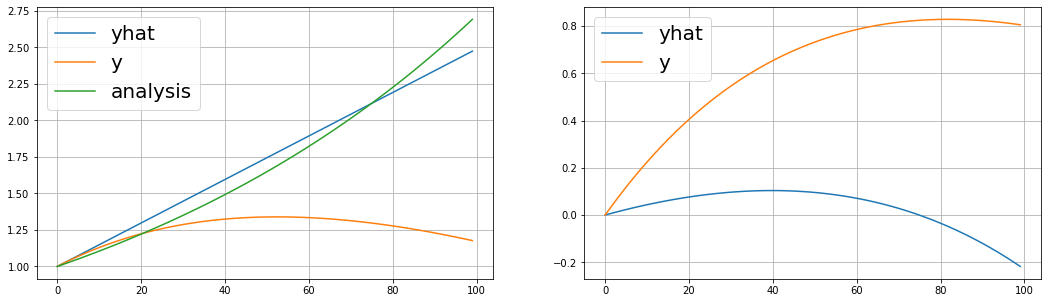

In [ ]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat, label = 'yhat')
ax.plot(yhat + [neural_network(EC_W, x[i])*x[i]**(n+1) for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(yhat - psy_analytic(x,1), label = 'yhat')
ax2.plot([yhat[i] + neural_network(EC_W, x[i])*x[i]**(n+1) for i in tf.range(tf.size(x))] - psy_analytic(x,-1), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [ ]:
# yhat 생성 2차
n_2 = 2
yhat_w_2, low_loss_2 = yhat_w_loss(x, n_2, early_stop=1)
yhat_2 = y(x, yhat_w_2, n_2, bias = 1)

# add EC
EC_W_2, loss_2 = EC_W_loss(x, yhat_2, n_2, early_stop=1, min_loss=low_loss_2)

In [ ]:
# yhat 생성 3차
n_3 = 3
yhat_w_3, low_loss_3 = yhat_w_loss(x, n_3, early_stop=1)
yhat_3 = y(x, yhat_w_3, n_3, bias = 1)

# add EC
EC_W_3, loss_3 = EC_W_loss(x, yhat_3, n_3, early_stop=1, min_loss=low_loss_3)

In [6]:
def EC_W_loss2(x, yhat, yhatprime, n = 4, min_loss = -1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start add EC')
    # w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    W = [tf.Variable(tf.random.normal(shape=(1, 10), dtype=tf.float32), trainable=True), 
        tf.Variable(tf.random.normal(shape=(10, 1), dtype=tf.float32), trainable=True)] 
    
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            for i in tf.range(tf.size(x)):
                loss_sum += tf.reduce_sum(tf.square(loss_function2(yhat[i], yhatprime[i], W, x[i])))

        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, W)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))

        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # min_loss가 loss_sum 보다 작아지면 멈춤
        if min_loss > loss_sum:
            print('min_loss')
            break

        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, loss_sum))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    return early_stop_w, low_loss

In [100]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w, low_loss = yhat_w_loss(x, n, early_stop=1)
yhat = y(x, yhat_w, n, bias = 1)
yhatprime = yprime(x, yhat_w, n, bias = 0)

Start yhat
Epoch : 1000, Loss_sum : 190.7194, w : [-0.7222116]
Epoch : 2000, Loss_sum : 94.0505, w : [0.06082783]
Epoch : 3000, Loss_sum : 46.2002, w : [0.69458777]
Epoch : 4000, Loss_sum : 28.5765, w : [1.1512312]
Epoch : 5000, Loss_sum : 24.9019, w : [1.4025179]
Epoch : 6000, Loss_sum : 24.6302, w : [1.4825044]
early stop
low_loss_Epoch : 6291, low_Loss_sum : 24.6274, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4883908], dtype=float32)>


In [101]:
# add EC
EC_W, loss = EC_W_loss2(x, yhat, yhatprime, n, early_stop=1)

Start add EC
Epoch : 0, Loss_sum : 18.9531
Epoch : 1000, Loss_sum : 0.8463
Epoch : 2000, Loss_sum : 0.8441
Epoch : 3000, Loss_sum : 0.8398
Epoch : 4000, Loss_sum : 0.8308
Epoch : 5000, Loss_sum : 0.8099
Epoch : 6000, Loss_sum : 0.7444
Epoch : 7000, Loss_sum : 0.5147
Epoch : 8000, Loss_sum : 0.3535
Epoch : 9000, Loss_sum : 0.2555
Epoch : 10000, Loss_sum : 0.1597
Epoch : 11000, Loss_sum : 0.1012
early stop
low_loss_Epoch : 11654, low_Loss_sum : 0.0836, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[ 5.2028913 , -0.6392374 , -0.64557576, -0.6524278 ,  7.5520806 ,
         3.231211  ,  0.79941624,  0.48906368,  4.8100004 , -0.87091696]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[-2.5648892 ],
       [-1.0299964 ],
       [-0.09924411],
       [-0.32840595],
       [ 3.8245416 ],
       [-0.7653055 ],
       [ 4.167777  ],
       [-0.46833768],
       [-2.7580476 ],
       [-1.1868079 ]], dtype=float32)>

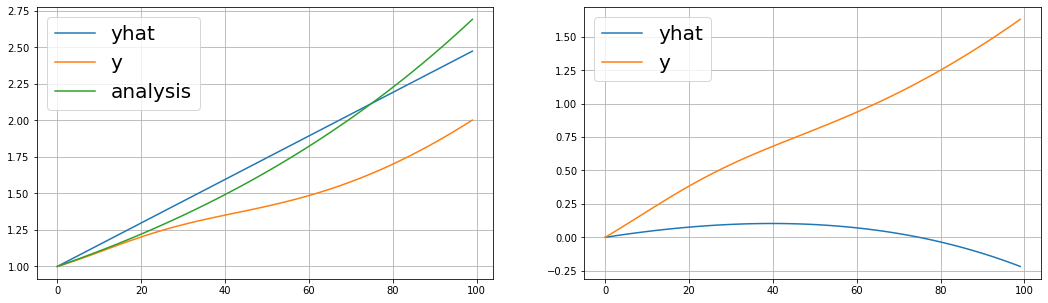

In [104]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat, label = 'yhat')
ax.plot(yhat + [neural_network(EC_W, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(yhat - psy_analytic(x,1), label = 'yhat')
ax2.plot([yhat[i] + neural_network(EC_W, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,-1), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [109]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_lossfunction2, low_loss_lossfunction2 = yhat_w_loss(x, n, early_stop=1)
yhat_lossfunction2 = y(x, yhat_w_lossfunction2, n, bias = 1)
yhatprime_lossfunction2 = yprime(x, yhat_w_lossfunction2, n, bias = 0)

# add EC
EC_W_lossfunction2, loss_lossfunction2 = EC_W_loss2(x, yhat_lossfunction2, yhatprime_lossfunction2, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 77.2685, w : [0.24598137]
Epoch : 2000, Loss_sum : 36.4540, w : [0.90183824]
Epoch : 3000, Loss_sum : 25.8402, w : [1.3034345]
Epoch : 4000, Loss_sum : 24.6560, w : [1.4632361]
early stop
low_loss_Epoch : 4595, low_Loss_sum : 24.6279, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4870067], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 176.6767
Epoch : 1000, Loss_sum : 0.8720
early stop
low_loss_Epoch : 1330, low_Loss_sum : 0.8664, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[-1.4318475 , -0.7643448 ,  0.05296753,  0.8771403 ,  1.1730112 ,
        -0.6651356 ,  0.17432255,  0.03028611, -0.853796  , -1.8592076 ]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[ 1.4824517 ],
       [-0.14151688],
       [-0.8095479 ],
       [ 0.6978573 ],
       [ 0.51663184],
       [-1.5946664 ],
       [ 1.1650342 ],
       [-0.21666971],
     

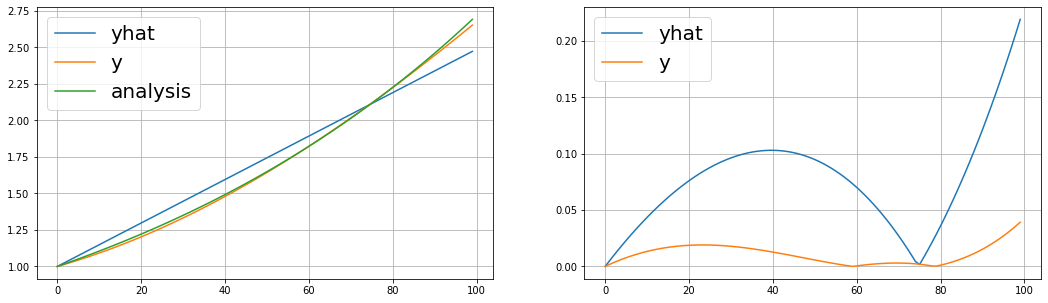

In [117]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_lossfunction2, label = 'yhat')
ax.plot(yhat_lossfunction2 + [neural_network(EC_W_lossfunction2, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_lossfunction2 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_lossfunction2 + [neural_network(EC_W_lossfunction2, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [163]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_loss2_1, low_loss_loss2_1 = yhat_w_loss(x, n, early_stop=1)
yhat_loss2_1 = y(x, yhat_w_loss2_1, n, bias = 1)
yhatprime_loss2_1 = yprime(x, yhat_w_loss2_1, n, bias = 0)

# add EC
EC_W_loss2_1, loss_loss2_1 = EC_W_loss2(x, yhat_loss2_1, yhatprime_loss2_1, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 271.1426, w : [-1.2058122]
Epoch : 2000, Loss_sum : 144.4533, w : [-0.38858873]
Epoch : 3000, Loss_sum : 72.0456, w : [0.30933383]
Epoch : 4000, Loss_sum : 37.8285, w : [0.8683727]
Epoch : 5000, Loss_sum : 26.5878, w : [1.2520795]
Epoch : 6000, Loss_sum : 24.7201, w : [1.4401209]
early stop
low_loss_Epoch : 6912, low_Loss_sum : 24.6279, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4870043], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 50.1869
Epoch : 1000, Loss_sum : 0.8188
Epoch : 2000, Loss_sum : 0.8150
Epoch : 3000, Loss_sum : 0.8063
Epoch : 4000, Loss_sum : 0.7825
Epoch : 5000, Loss_sum : 0.7053
Epoch : 6000, Loss_sum : 0.5022
Epoch : 7000, Loss_sum : 0.2461
Epoch : 8000, Loss_sum : 0.1525
Epoch : 9000, Loss_sum : 0.1219
Epoch : 10000, Loss_sum : 0.0904
Epoch : 11000, Loss_sum : 0.0651
Epoch : 12000, Loss_sum : 0.0527
early stop
low_loss_Epoch : 12698, low_Loss_sum : 0.0494, low_loss_w : [<tf.Variable 'Var

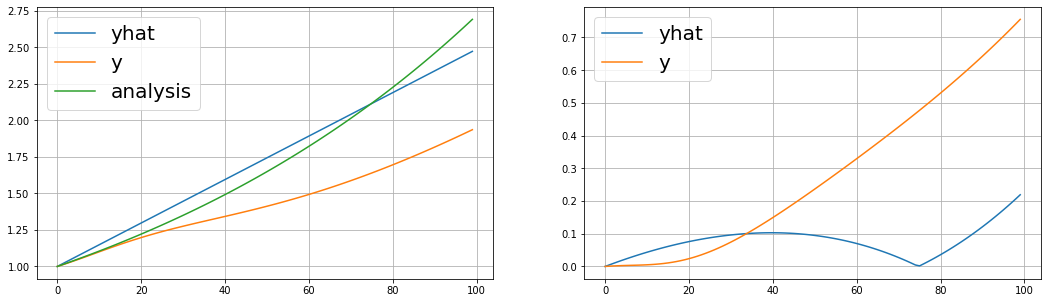

In [165]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_loss2_1, label = 'yhat')
ax.plot(yhat_loss2_1 + [neural_network(EC_W_loss2_1, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_loss2_1 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_loss2_1 + [neural_network(EC_W_loss2_1, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [166]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_loss2_2, low_loss_loss2_2 = yhat_w_loss(x, n, early_stop=1)
yhat_loss2_2 = y(x, yhat_w_loss2_2, n, bias = 1)
yhatprime_loss2_2 = yprime(x, yhat_w_loss2_2, n, bias = 0)

# add EC
EC_W_loss2_2, loss_loss2_2 = EC_W_loss2(x, yhat_loss2_2, yhatprime_loss2_2, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 125.6450, w : [-0.23453163]
Epoch : 2000, Loss_sum : 58.1037, w : [0.49848452]
Epoch : 3000, Loss_sum : 31.6250, w : [1.0381807]
Epoch : 4000, Loss_sum : 25.2516, w : [1.3568555]
Epoch : 5000, Loss_sum : 24.6388, w : [1.4737933]
early stop
low_loss_Epoch : 5536, low_Loss_sum : 24.6273, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.488618], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 38.0295
Epoch : 1000, Loss_sum : 0.8631
early stop
low_loss_Epoch : 1008, low_Loss_sum : 0.8631, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[-0.03138588, -1.6425983 , -0.14165916, -0.28274176,  0.67458254,
        -1.7125494 , -0.3223391 ,  0.46502405,  1.5104669 , -0.76203716]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[ 0.96544665],
       [-0.24547954],
       [-1.6949806 ],
       [ 1.0536016 ],
       [-0.12282286],
       [-0.3753868 ],

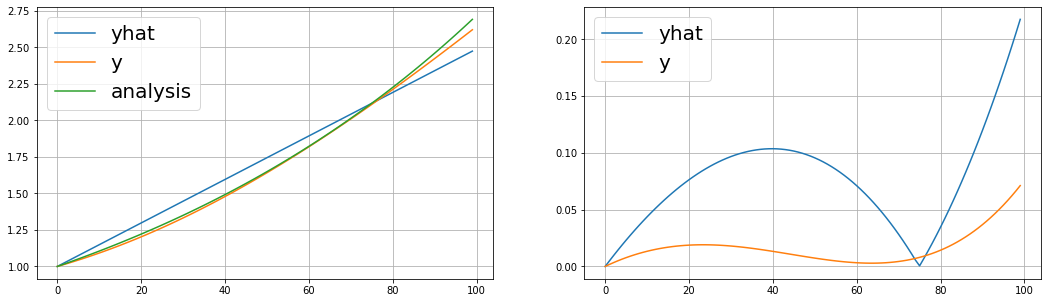

In [167]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_loss2_2, label = 'yhat')
ax.plot(yhat_loss2_2 + [neural_network(EC_W_loss2_2, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_loss2_2 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_loss2_2 + [neural_network(EC_W_loss2_2, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [7]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_loss2_3, low_loss_loss2_3 = yhat_w_loss(x, n, early_stop=1)
yhat_loss2_3 = y(x, yhat_w_loss2_3, n, bias = 1)
yhatprime_loss2_3 = yprime(x, yhat_w_loss2_3, n, bias = 0)

# add EC
EC_W_loss2_3, loss_loss2_3 = EC_W_loss2(x, yhat_loss2_3, yhatprime_loss2_3, n, early_stop=1, min_loss=0.8664)

Start yhat
Epoch : 1000, Loss_sum : 29.6495, w : [1.1078023]
Epoch : 2000, Loss_sum : 24.7305, w : [1.4373196]
early stop
low_loss_Epoch : 2825, low_Loss_sum : 24.6273, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4888586], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 84.6169
min_loss
low_loss_Epoch : 781, low_Loss_sum : 0.8659, low_loss_w : [<tf.Variable 'Variable:0' shape=(1, 10) dtype=float32, numpy=
array([[-1.2668686 , -0.26394486,  1.0090863 ,  0.3355653 , -0.30545807,
        -0.5376998 ,  0.44999346, -3.5080743 ,  0.7671637 ,  1.8747886 ]],
      dtype=float32)>, <tf.Variable 'Variable:0' shape=(10, 1) dtype=float32, numpy=
array([[-0.94188523],
       [ 1.3684897 ],
       [ 1.2701597 ],
       [-0.62231135],
       [ 0.06397426],
       [-0.70267916],
       [-1.5714092 ],
       [-0.6027255 ],
       [ 0.72810394],
       [-0.25363958]], dtype=float32)>]


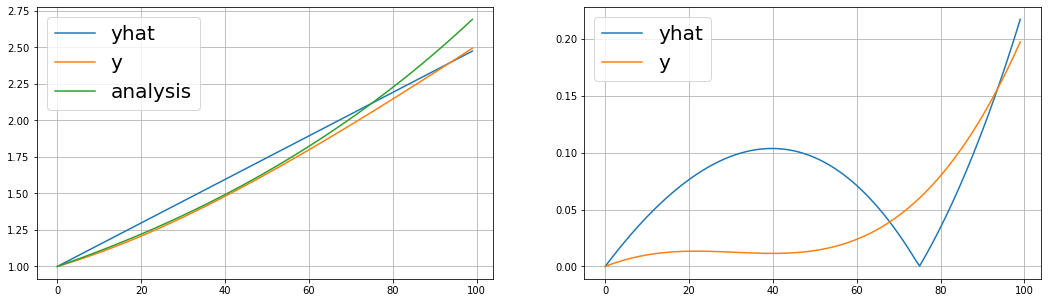

In [9]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_loss2_3, label = 'yhat')
ax.plot(yhat_loss2_3 + [neural_network(EC_W_loss2_3, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_loss2_3 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_loss2_3 + [neural_network(EC_W_loss2_3, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [7]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_loss2_4, low_loss_loss2_4 = yhat_w_loss(x, n, early_stop=1)
yhat_loss2_4 = y(x, yhat_w_loss2_4, n, bias = 1)
yhatprime_loss2_4 = yprime(x, yhat_w_loss2_4, n, bias = 0)

# add EC
EC_W_loss2_4, loss_loss2_4 = EC_W_loss2(x, yhat_loss2_4, yhatprime_loss2_4, n, early_stop=1, min_loss=0.8664)

Start yhat
Epoch : 1000, Loss_sum : 26.8124, w : [1.2388448]
Epoch : 2000, Loss_sum : 24.6403, w : [1.4726772]
early stop
low_loss_Epoch : 2434, low_Loss_sum : 24.6273, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4888779], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 82.2115


In [ ]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_loss2_4, label = 'yhat')
ax.plot(yhat_loss2_4 + [neural_network(EC_W_loss2_4, x[i])*x[i] for i in tf.range(tf.size(x))], label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_loss2_4 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_loss2_4 + [neural_network(EC_W_loss2_4, x[i])*x[i] for i in tf.range(tf.size(x))] - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()

In [108]:
def EC_W_loss2_100(x, yhat, yhatprime, n = 4, min_loss = -1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start add EC')
    # w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    W = [tf.Variable(tf.random.normal(shape=(100, 10), dtype=tf.float32), trainable=True), 
        tf.Variable(tf.random.normal(shape=(10, 100), dtype=tf.float32), trainable=True)] 
    
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = tf.math.reduce_sum(tf.square(loss_function2(yhat, yhatprime, W, x)))

        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, W)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))

        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # min_loss가 loss_sum 보다 작아지면 멈춤
        if min_loss > loss_sum:
            print('min_loss')
            break

        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, loss_sum))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    return early_stop_w, low_loss

In [141]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_100_2, low_loss_100_2 = yhat_w_loss(x, n, early_stop=1)
yhat_100_2 = y(x, yhat_w_100_2, n, bias = 1)
yhatprime_100_2 = yprime(x, yhat_w_100_2, n, bias = 0)

# add EC
EC_W_100_2, loss_100_2 = EC_W_loss2_100(x, yhat_100_2, yhatprime_100_2, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 42.5678, w : [0.7650361]
Epoch : 2000, Loss_sum : 26.2777, w : [1.2719861]
Epoch : 3000, Loss_sum : 24.6569, w : [1.4628109]
early stop
low_loss_Epoch : 3646, low_Loss_sum : 24.6274, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4885254], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 1839.6125
Epoch : 1000, Loss_sum : 1.9448
Epoch : 2000, Loss_sum : 0.0122
early stop
low_loss_Epoch : 2112, low_Loss_sum : 0.0060, low_loss_w : [<tf.Variable 'Variable:0' shape=(100, 10) dtype=float32, numpy=
array([[-8.82601857e-01,  1.13377368e+00,  1.67985067e-01,
        -1.51616979e+00, -9.11633670e-01,  1.12629461e+00,
         4.28431898e-01, -1.66904187e+00, -1.52659953e+00,
         7.65036568e-02],
       [ 7.60534331e-02, -4.12516296e-01, -7.37520039e-01,
        -8.77649724e-01,  3.15104760e-02,  3.60992879e-01,
         4.67400044e-01, -2.30513620e+00, -4.47663218e-01,
        -3.10299486e-01],
       [-2.98819512e-01, 

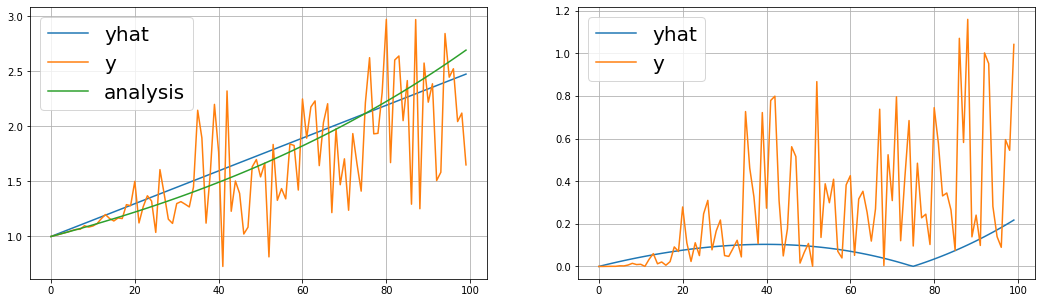

In [143]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_100_2, label = 'yhat')
ax.plot(yhat_100_2 + dot(sigmoid(dot(x, EC_W_100_2[0])), EC_W_100_2[1])*x, label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_100_2 - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_100_2 + dot(sigmoid(dot(x, EC_W_100_2[0])), EC_W_100_2[1])*x - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()


In [154]:
def EC_W_loss2_100_ori(x, yhat, yhatprime, n = 4, min_loss = -1, target_loss = np.Inf, early_stop = np.Inf, max_train_count = np.Inf):
    print('Start add EC')
    # w = tf.Variable(tf.random.normal(shape=(n,), dtype=tf.float32), trainable=True) # w = [weight1, weight2, weight3, weight4, ... , weight(n)]
    W = [tf.Variable(tf.random.normal(shape=(100, 10), dtype=tf.float32), trainable=True), 
        tf.Variable(tf.random.normal(shape=(10, 100), dtype=tf.float32), trainable=True)] 
    
    # 원하는 loss 값에 도달할 때 까지 Epoch 횟수 올리기
    Epoch = 0

    # 옵티마이져 종류 Adam, SDG, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl 가능
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)

    # 학습 과정
    low_loss = np.inf
    low_loss_Epoch = 0
    while True:
        loss_sum = 0.0
        with tf.GradientTape() as tape:
            loss_sum = loss_function2_ori(yhat, yhatprime, W, x, n)

        # Gradient 값 저장
        gradients = tape.gradient(loss_sum, W)
        # Gradient 값 w에 적용
        optimizer.apply_gradients(zip([gradients[0], gradients[1]], [W[0], W[1]]))

        # early stop
        if target_loss >= loss_sum and low_loss > loss_sum:
            low_loss = loss_sum
            early_stop_w = W
            low_loss_Epoch = Epoch
        
        if low_loss_Epoch != 0 and low_loss_Epoch + early_stop <= Epoch:
            print('early stop')
            break

        # min_loss가 loss_sum 보다 작아지면 멈춤
        if min_loss > loss_sum:
            print('min_loss')
            break

        if Epoch % 1000 == 0:
            print('Epoch : {}, Loss_sum : {:.4f}'.format(Epoch, loss_sum))

        if Epoch == max_train_count:
            print('max count')
            break
        Epoch += 1
    print('low_loss_Epoch : {}, low_Loss_sum : {:.4f}, low_loss_w : {}'.format(low_loss_Epoch, low_loss, early_stop_w))

    return early_stop_w, low_loss

In [155]:
# 최대 x 범위 : start <= x < limit, delta로 슬라이싱
start, limit, delta = 0, 1, 0.01
x = tf.Variable(tf.range(start, limit, delta))

# yhat 생성
n = 1
yhat_w_100_2_ori, low_loss_100_2_ori = yhat_w_loss(x, n, early_stop=1)
yhat_100_2_ori = y(x, yhat_w_100_2_ori, n, bias = 1)
yhatprime_100_2_ori = yprime(x, yhat_w_100_2_ori, n, bias = 0)

# add EC
EC_W_100_2_ori, loss_100_2_ori = EC_W_loss2_100_ori(x, yhat_100_2_ori, yhatprime_100_2_ori, n, early_stop=1)

Start yhat
Epoch : 1000, Loss_sum : 46.3989, w : [0.6910655]
Epoch : 2000, Loss_sum : 27.0383, w : [1.2259405]
Epoch : 3000, Loss_sum : 24.6899, w : [1.4494547]
early stop
low_loss_Epoch : 3761, low_Loss_sum : 24.6276, low_loss_w : <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.4877976], dtype=float32)>
Start add EC
Epoch : 0, Loss_sum : 4424.8179
Epoch : 1000, Loss_sum : 7.1029
Epoch : 2000, Loss_sum : 0.0011
early stop
low_loss_Epoch : 2746, low_Loss_sum : 0.0000, low_loss_w : [<tf.Variable 'Variable:0' shape=(100, 10) dtype=float32, numpy=
array([[-1.18437457e+00, -1.18048477e+00,  9.39738452e-02,
        -6.29989028e-01, -1.57949537e-01, -1.21909849e-01,
         5.48079729e-01, -6.61501467e-01,  1.92517847e-01,
        -6.51556611e-01],
       [ 1.64626265e+00, -6.12720311e-01,  6.85628951e-01,
        -2.39261016e-01,  7.65921950e-01, -6.85962141e-01,
        -1.36718333e+00,  3.52887720e-01,  1.60864383e-01,
        -4.83265430e-01],
       [ 2.09523112e-01, 

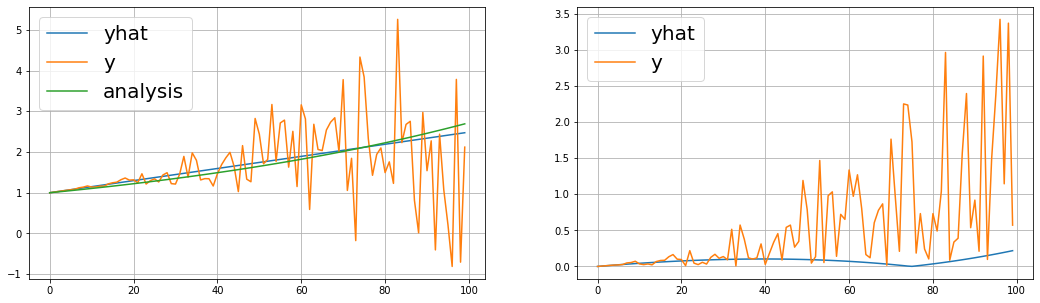

In [156]:
# Graph
fig = plt.figure(figsize=(18,5))
ax = fig.add_subplot(121)
ax.plot(yhat_100_2_ori, label = 'yhat')
ax.plot(yhat_100_2_ori + dot(sigmoid(dot(x, EC_W_100_2_ori[0])), EC_W_100_2_ori[1])*x**(n+1), label = 'y')
ax.plot(psy_analytic(x,1), label = 'analysis')
ax.tick_params(labelsize=10)
ax.legend(fontsize=20)
ax.grid()
# Error
ax2 = fig.add_subplot(122)
ax2.plot(abs(yhat_100_2_ori - psy_analytic(x,1)), label = 'yhat')
ax2.plot(abs(yhat_100_2_ori + dot(sigmoid(dot(x, EC_W_100_2_ori[0])), EC_W_100_2_ori[1])*x**(n+1) - psy_analytic(x,1)), label = 'y')
ax2.tick_params(labelsize=10)
ax2.legend(fontsize=20)
ax2.grid()
